In [1]:
import numpy as np
import cv2
import os 

import seaborn as sns
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_confusion_matrix as plt_con_mat

from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten
from keras.utils import plot_model

In [2]:
ROW = 128
COL = 128

path = "../input/utkface-new/UTKFace"

In [3]:
file_names = os.listdir(path)

gender = [i.split('_')[1] for i in file_names]
y_data = np.array([int(i) for i in gender])
y_data = np.expand_dims(y_data, axis = -1)

print(y_data.shape)

(23708, 1)


In [4]:
X_data = np.array([cv2.resize(cv2.imread(os.path.join(path,file)), (ROW, COL)) for file in file_names])
print(X_data.shape)

(23708, 128, 128, 3)


In [5]:
y_data = to_categorical(y_data)

X_temp, X_val, y_temp, y_val = train_test_split(X_data, y_data, test_size = 0.1, shuffle = True, random_state = 1)
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size = 0.1, random_state = 1)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(19203, 128, 128, 3) (19203, 2)
(2371, 128, 128, 3) (2371, 2)
(2134, 128, 128, 3) (2134, 2)


## Visualising the data

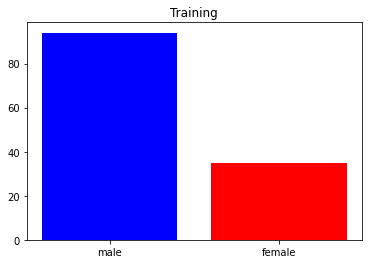

In [6]:
idxs = [0,1]
x_ticks = ['male', 'female']

plt.bar(idxs, [len([i for i in X_train if np.argmax(i) == 0]), 
                len([i for i in X_train if np.argmax(i) == 1])
               ],
       color = ['b','r'])
plt.xticks(idxs, x_ticks)
plt.title('Training')
plt.show()

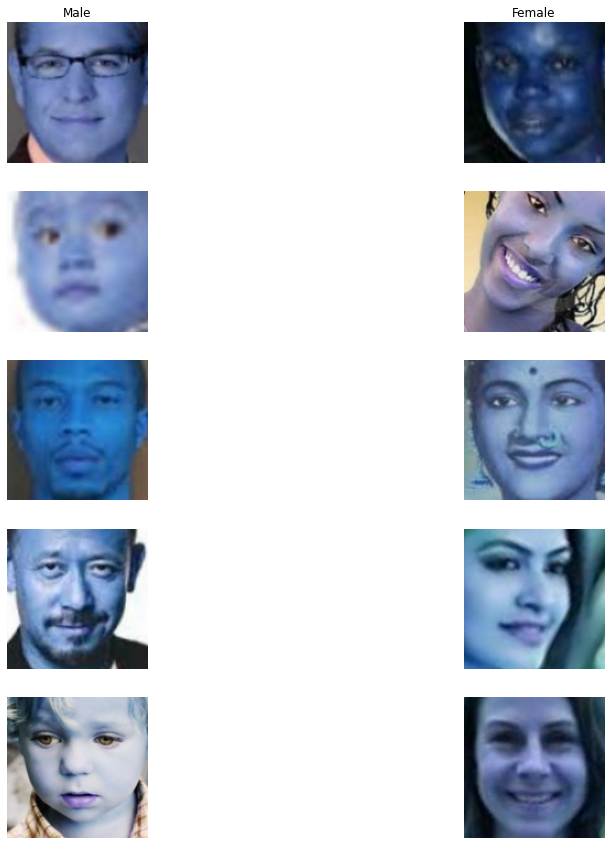

In [7]:
m = 0
f = 0

male_images = []
female_images = []

for idx, label in enumerate(y_train):

    if(m <= 5 and np.argmax(label) == 0):
        male_images.append(idx)
        m += 1
    elif(f <= 5):
        female_images.append(idx)
        f += 1
        
    if(m == 5 and f == 5):
        break
        
fig, ax = plt.subplots(5, 2, figsize = (15, 15))

ax[0, 0].title.set_text("Male")
ax[0, 1].title.set_text("Female")

for i in range(5):
    
    ax[i, 0].imshow(X_train[male_images[i]])
    ax[i, 0].axis('off')
    ax[i, 1].imshow(X_train[female_images[i]])
    ax[i, 1].axis('off')

plt.show()

In [8]:
model = Sequential()

model.add(Conv2D(16, kernel_size = (3, 3), activation = 'relu', input_shape = (ROW, COL, 3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 59, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 128)       0

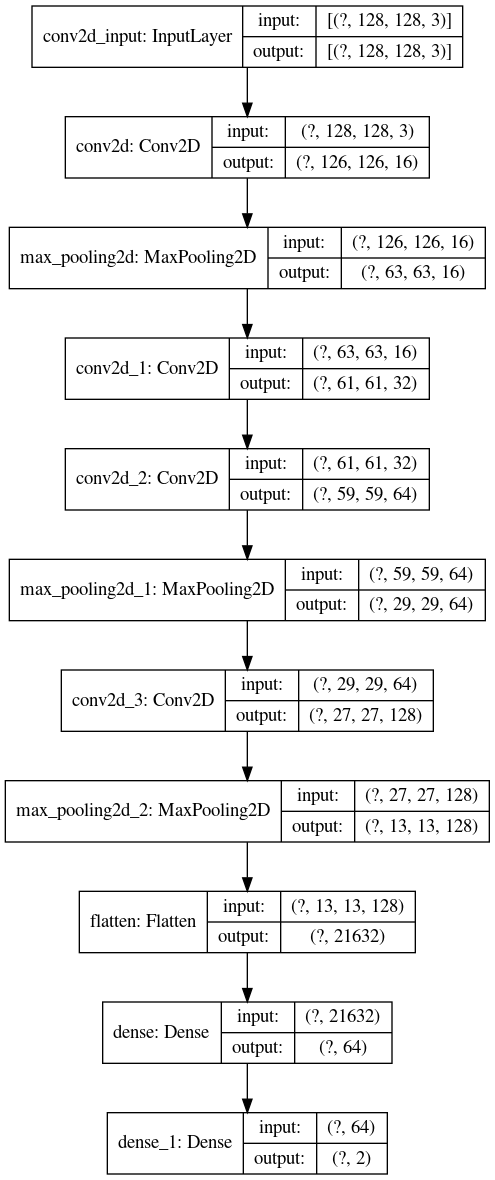

In [9]:
plot_model(model, show_shapes=True, show_layer_names=True)

## Training the model

In [10]:
model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy', 'Precision', 'Recall'])

history = model.fit(X_train, y_train, 
                    validation_data = (X_val, y_val), 
                    epochs = 15,
                    batch_size = 64)

Epoch 1/15
301/301 [==============================] - 309s 1s/step - loss: 4.2009 - accuracy: 0.7733 - precision: 0.7733 - recall: 0.7733 - val_loss: 0.3352 - val_accuracy: 0.8617 - val_precision: 0.8617 - val_recall: 0.8617
Epoch 2/15
301/301 [==============================] - 307s 1s/step - loss: 0.3153 - accuracy: 0.8682 - precision: 0.8682 - recall: 0.8682 - val_loss: 0.3036 - val_accuracy: 0.8655 - val_precision: 0.8655 - val_recall: 0.8655
Epoch 3/15
301/301 [==============================] - 309s 1s/step - loss: 0.2804 - accuracy: 0.8792 - precision: 0.8792 - recall: 0.8792 - val_loss: 0.2888 - val_accuracy: 0.8743 - val_precision: 0.8743 - val_recall: 0.8743
Epoch 4/15
301/301 [==============================] - 310s 1s/step - loss: 0.2464 - accuracy: 0.8954 - precision: 0.8954 - recall: 0.8954 - val_loss: 0.2649 - val_accuracy: 0.8916 - val_precision: 0.8916 - val_recall: 0.8916
Epoch 5/15
301/301 [==============================] - 315s 1s/step - loss: 0.2257 - accuracy: 0.9031

## Visualising the performance of the model

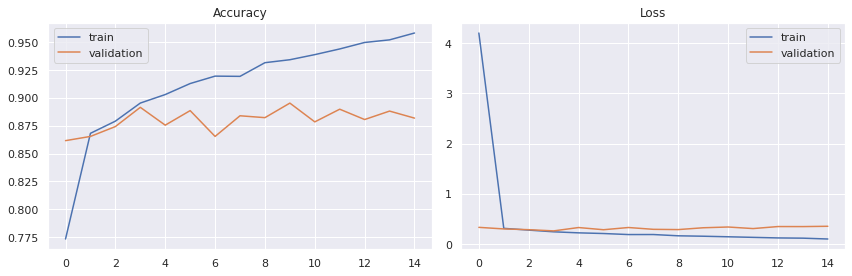

In [11]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label = 'train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label = 'validation')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label = 'train')
sns.lineplot(history.epoch, history.history['val_loss'], label = 'validation')
plt.title('Loss')
plt.tight_layout()

#plt.savefig('epoch_history.png')
plt.show()